In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from xdgmm import XDGMM

In [2]:
highDustFile = 'hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12056-m31-b15_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits'
lowDustFile = 'hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits'

In [3]:
dustLow = fits.open(lowDustFile)[1].data
dustHigh = fits.open(highDustFile)[1].data

You’d want the VEGAMAG in the F110W and F160W filters, in the *st.fits files.  
So, columns like “F110W_vega” and “F110W_err” and “F160W_vega” and “F160W_err”.  
Select the stars that pass the F110W_gst and F160W_gst flags (i.e., “good” photometry)


In [16]:
def getArrays(arr, magSN=64.):
    good = (arr['f160w_gst'] == True) & (arr['f110w_gst'] == True) & (arr['f110w_err'] > 0.0) & (arr['f160w_err'] > 0.0)
    J = arr['f110w_vega'][good]
    H = arr['f160w_vega'][good]
    Jerr = arr['f110w_err'][good]
    Herr = arr['f160w_err'][good]

    mag = H
    color = J-H
    magErr = Herr
    colorErr = np.sqrt(Jerr**2. + Herr**2.)

    sigMax = 1.086/magSN
    highSN = (Jerr < sigMax) & (Herr < sigMax)
    return mag, color, magErr, colorErr, highSN

In [70]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)


In [ ]:
def matrixize(data1, data2, err1, err2):
    """
    vectorize the 2 pieces of data into a 2D mean and 2D covariance matrix
    """
    X = np.vstack([data1, data2]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xerr[:, diag, diag] = np.vstack([err1**2., err2**2.]).T
    return X, Xerr

62092 dustlow
130444 dusthigh


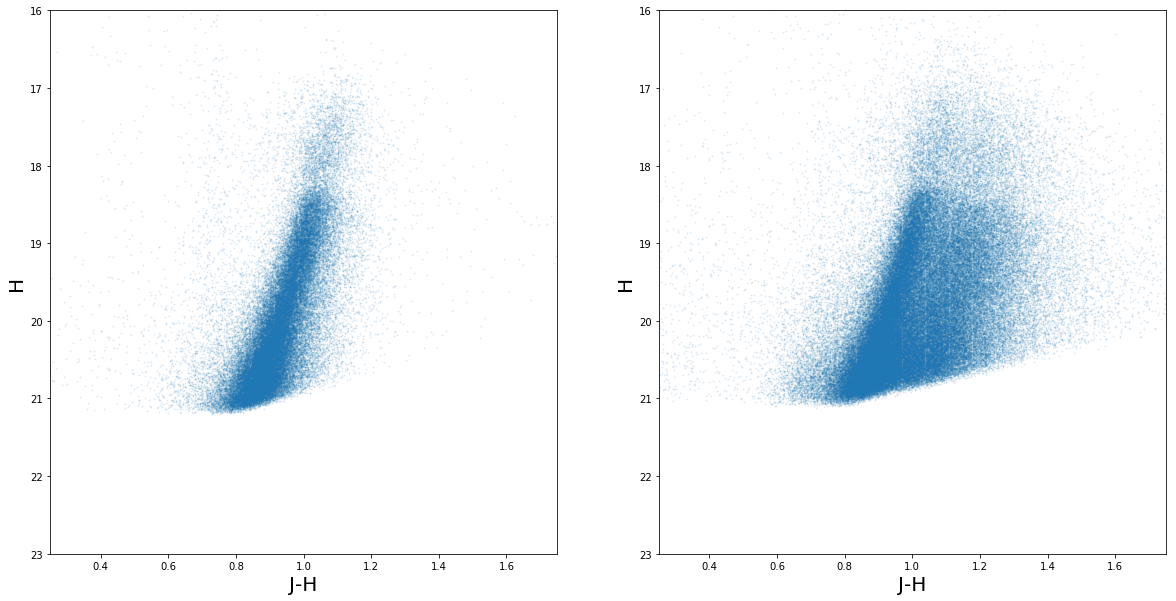

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
names = ['dustlow', 'dusthigh']
for i, (a, arr, n) in enumerate(zip(ax, [dustLow, dustHigh], names)):
    mag, color, magErr, colorErr, highSN = getArrays(arr, magSN = 128.)
    print np.sum(highSN), n
    ax[i].scatter(color[highSN], mag[highSN], s=1, alpha=0.1)
    ax[i].set_xlim(0.25, 1.75)
    ax[i].set_ylim(23, 16)
    ax[i].set_xlabel('J-H', fontsize=20)
    ax[i].set_ylabel('H', fontsize=20)

In [20]:
mag, color, magErr, colorErr, highSN = getArrays(dustLow, magSN=128.)
X, Xerr = matrixize(color[highSN], mag[highSN], colorErr[highSN], magErr[highSN])
xdgmm = XDGMM(method='Bovy')
xdgmm.n_components = 16
xdgmm = xdgmm.fit(X, Xerr)
xdgmm.save_model('dustM31_lowdust.fits')
sample = xdgmm.sample(np.sum(highSN))

62092


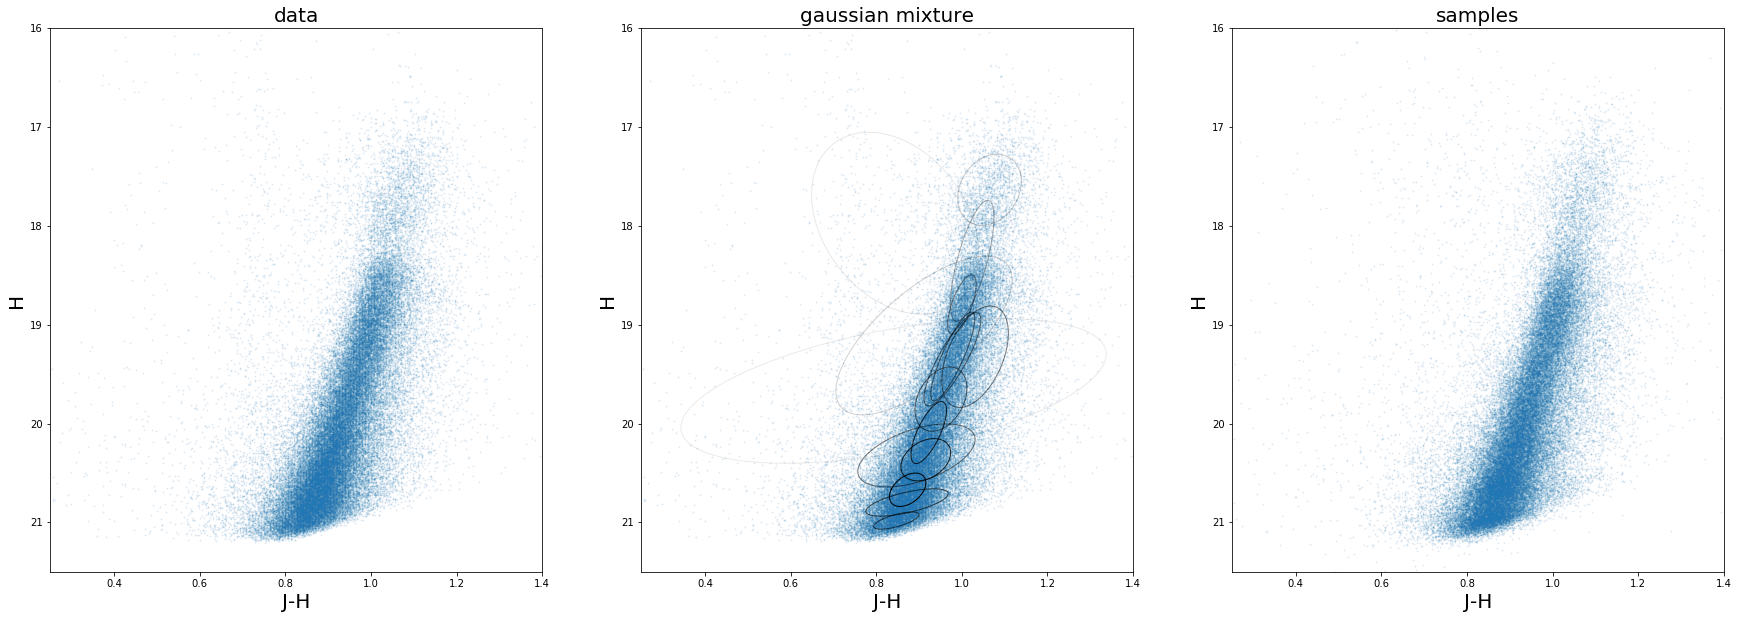

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].scatter(color[highSN], mag[highSN], s=1, alpha=0.1)
ax[1].scatter(color[highSN], mag[highSN], s=1, alpha=0.1)
ax[2].scatter(sample[:,0], sample[:,1], s=1, alpha=0.1)
plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('J-H', fontsize=20)
    a.set_ylabel('H', fontsize=20)
    a.set_xlim(0.25, 1.4)
    a.set_ylim(21.5, 16)
    a.set_xlabel('J-H', fontsize=20)
    a.set_ylabel('H', fontsize=20)
    a.set_title(l, fontsize=20)


In [50]:
mag, color, magErr, colorErr, highSN = getArrays(dustHigh, magSN=128.)
X, Xerr = matrixize(color[highSN], mag[highSN], colorErr[highSN], magErr[highSN])
xdgmm = XDGMM(method='Bovy')
xdgmm.n_components = 16
xdgmm = xdgmm.fit(X, Xerr)
xdgmm.save_model('dustM31_highdust.fits')
sample = xdgmm.sample(np.sum(highSN))

//anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multiva

NameError: name 'dustM31_highdust' is not defined

In [51]:
xdgmm.save_model('dustM31_highdust.fits')
sample = xdgmm.sample(np.sum(highSN))

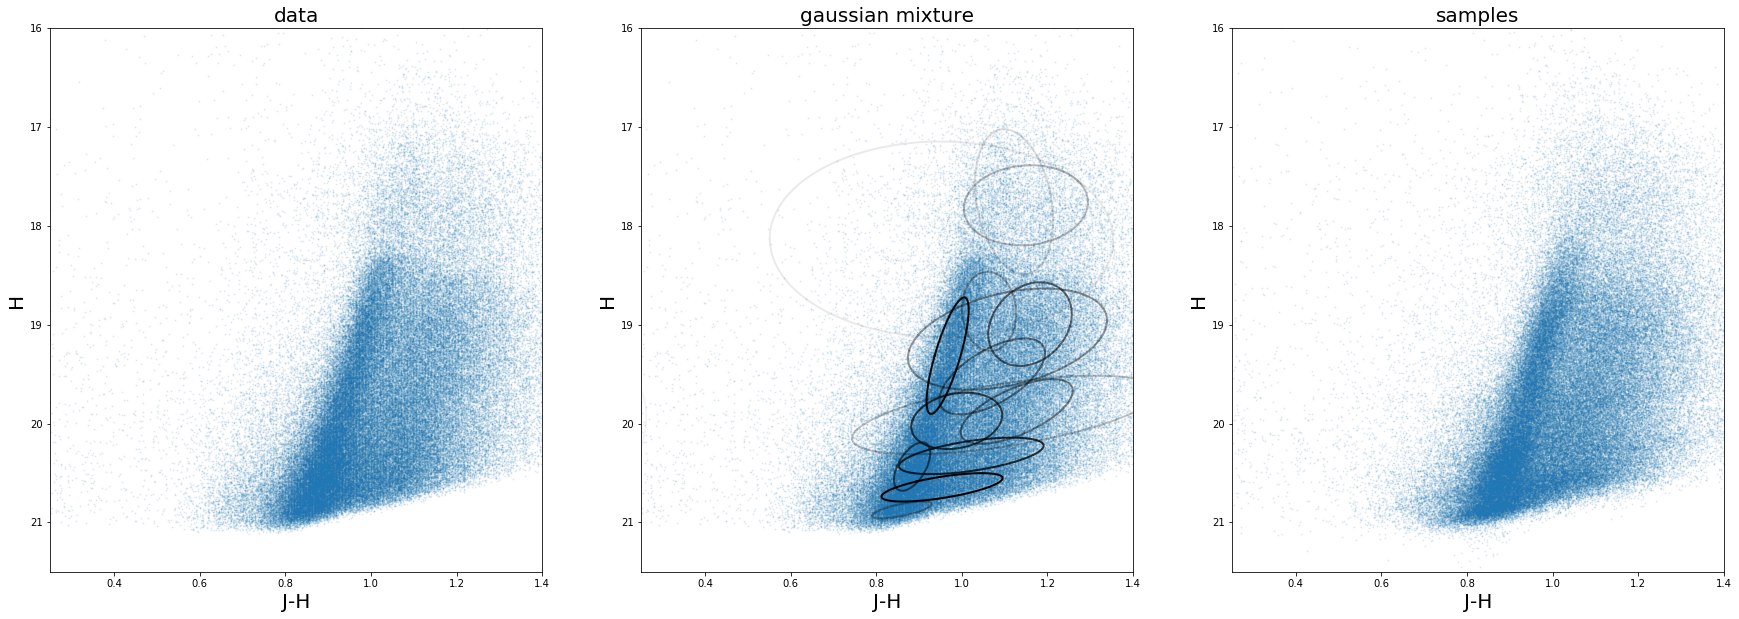

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].scatter(color[highSN], mag[highSN], s=1, alpha=0.1)
ax[1].scatter(color[highSN], mag[highSN], s=1, alpha=0.1)
ax[2].scatter(sample[:,0], sample[:,1], s=1, alpha=0.1)
plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('J-H', fontsize=20)
    a.set_ylabel('H', fontsize=20)
    a.set_xlim(0.25, 1.4)
    a.set_ylim(21.5, 16)
    a.set_title(l, fontsize=20)


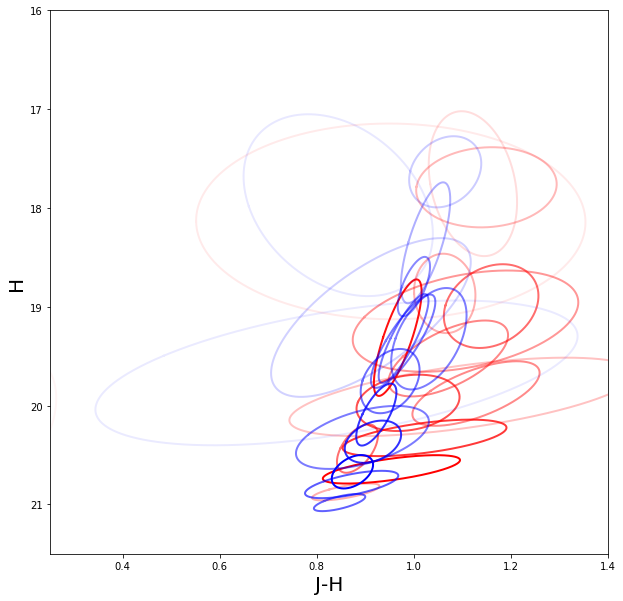

In [72]:
fig, ax = plt.subplots(figsize=(10 ,10))
files = ['dustM31_highdust.fits', 'dustM31.fits']
c1 = '#a6cee3'
c2 = '#1f78b4'
c3 = '#b2df8a'
c4 = '#33a02c'
colors = ['red', 'blue']
labels = ['high dust', 'low dust']
for f, c, l in zip(files, colors, labels):
    xdgmm = XDGMM(filename=f)
    plotXdgmm(xdgmm, ax, lw=2, c=c, label=l)
ax.set_xlabel('J-H', fontsize=20)
ax.set_ylabel('H', fontsize=20)
ax.set_xlim(0.25, 1.4)
ax.set_ylim(21.5, 16)
ax.legend()